In [1]:
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from skimage import measure
import glob
import os
from math import floor
from tqdm import tnrange, tqdm_notebook
import json
from scipy.ndimage.measurements import label
from math import floor, ceil
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import smtplib, ssl
%matplotlib inline

## Read in image and find dimensions

In [8]:
class Config():
    # Number of tiles to slice the image into. Must be a square rootable number. 
    NUM_SLICES = 9
    
    # When we stride the image, how much overlap do we want? Put as percentage
    TILE_OVERLAP = 0.1

In [10]:
class Slicer():
    def __init__(self, image_dir, img_output_dir, annotation_file, config, output_file = None):
        assert os.path.isdir(os.getcwd() + "/" + image_dir), "Image directory does not exist at path: {}".format(image_dir)
        assert os.path.isfile(os.getcwd() + "/" + annotation_file), "Annotation file does not exist at path: {}".format(annotation_file)
        assert config.NUM_SLICES == int(sqrt(config.NUM_SLICES + 0.5))**2 or config.NUM_SLICES == 1, "NUM_SLICES must be an evenly square rootable number or 1"
        if not os.path.isdir(os.getcwd() + "/" + img_output_dir):
            print("Made image output directory at {}".format(img_output_dir))
            os.mkdir(os.getcwd() + "/" + img_output_dir)
        
        self.image_dir = image_dir
        self.img_output_dir = img_output_dir
        self.config = config
        self.output_file = output_file
        self.coco_annotation = COCO(annotation_file)
        self.sliced_annotations = {
            "images": [], 
            "annotations": [], 
            "categories": [
                {
                    'id': 1, 
                    'name': 'Structure', 
                    'supercategory': 'Structure'
                }
            ]
        }
        
    def slice_dataset(self, save_masks = False):
        # Get image IDs for all images in dataset
        imgIds = self.coco_annotation.getImgIds()
        images = self.coco_annotation.loadImgs(ids = imgIds)
        
        image_num = 0
        image_id = 0
        annotation_id = 0
        
        for x in tnrange(len(imgIds), desc='Processing images...'):

            # Try to open image. Otherwise, continue
            try:
                im = Image.open(self.image_dir + "/{}".format(images[x]["file_name"]))
            except:
                continue
            print("Processing image: {}".format(images[x]["file_name"]))
            
            # Get rows and cols
            rows = im.size[0]
            cols = im.size[1]
            
            # Get num rows and cols for each slice
            slice_rows = floor(rows / self.config.NUM_SLICES)
            slice_cols = floor(cols / self.config.NUM_SLICES)
            
            # Calculate the x and y stride values
            x_stride = floor(slice_cols * (1 - self.config.TILE_OVERLAP))
            y_stride = floor(slice_rows * (1 - self.config.TILE_OVERLAP))
            
            # Get annotation IDs pertaining to image
            annIds = self.coco_annotation.getAnnIds(imgIds = imgIds[x])

            # Get all annotations pertaining to image
            annotations = self.coco_annotation.loadAnns(ids = annIds)

            # Get original mask of image
            original_mask = self.coco_annotation.annToMask(annotations[0])
            
            for j in tnrange(len(annotations), desc='Creating mask...'):
                original_mask += self.coco_annotation.annToMask(annotations[j])
            
            # Perform operations on each crop. Traverse image
            for i in range(slice_rows, rows, y_stride):
                for j in range(slice_cols, cols, x_stride):
                    
                    # Crop image
                    im_crop = im.crop((j - slice_cols, i - slice_rows, j, i))
                    
                    # Crop mask and pad with zeros
                    mask_crop = original_mask[i - slice_rows : i, j - slice_cols : j]
                    mask_crop_pad = np.zeros((mask_crop.shape[0] + 2, mask_crop.shape[1] + 2))
                    mask_crop_pad[1:mask_crop.shape[0] + 1, 1:mask_crop.shape[1] + 1] = mask_crop
                    mask_crop = mask_crop_pad
                    
                    # Check if sizes between cropped image and cropped mask are different. Also check
                    # if the cropped mask is empty. If so, skip
                    if im_crop.size[0] != mask_crop.shape[1] - 2 or im_crop.size[1] != mask_crop.shape[0] - 2:
                        continue
                    if np.sum(mask_crop) == 0:
                        continue
                    
                    # Try to save image in output dir. Otherwise, continue
                    try:
                        im_crop.save(self.img_output_dir + "/{}.jpg".format(image_num))
                    except Exception as e:
                        continue
                    
                    if save_masks:
                        # Prepare mask to save as image
                        binary_mask_to_int = mask_crop.astype(np.uint8)
                        binary_mask_to_int[binary_mask_to_int > 0] = 255
                        binary_mask_to_int = Image.fromarray(binary_mask_to_int)
                        binary_mask_to_int.save(self.img_output_dir + "/{}-mask.jpg".format(image_num))
                    
                    # Add image annotation to COCO JSON collection
                    self.sliced_annotations["images"].append({
                        'id': image_id, 
                        'file_name': "{}.jpg".format(image_num), 
                        'width': im_crop.size[0], 
                        'height': im_crop.size[1]
                    })
                    
                    # Increment image_num
                    image_num = image_num + 1
                    
                    contours = measure.find_contours(mask_crop, 0.5)
                    segmentations = list()

                    # Add segmentations to each annotation
                    for contour in contours:
                        contour = np.flip(contour, axis=1)
                        segmentation = contour.ravel().tolist()
                        segmentations.append(segmentation)
                    
                    for segmentation in segmentations:
                        
                        # Group segmentations into pairs
                        segmentations_grouped = [[segmentation[i], segmentation[i + 1]] for i in range(0, len(segmentation) - 2, 2)]
                        
                        # Determine the boundaries of the bounding box
                        top = np.inf
                        bottom = 0
                        left = np.inf
                        right = 0
                        
                        for index in segmentations_grouped:
                            if index[0] < top:
                                top = index[0]
                            if index[0] > bottom:
                                bottom = index[0]
                            if index[1] < left:
                                left = index[1]
                            if index[1] > right:                      
                                right = index[1] 
                        
                        # Get largest connected component to find area
                        bbox_crop = mask_crop[floor(left) : ceil(right), floor(top) : ceil(bottom)]
                        
                        # Construct 3x3 filter of ones
                        structure = np.ones((3, 3), dtype = np.int)
                        
                        # Separate out connected components
                        labeled, ncomponents = label(bbox_crop, structure)
                        
                        # Find the area of the largest connected component
                        max_len = 0

                        for num in range(1, ncomponents + 1, 1):
                            this_len = 0
                            for row in range(np.shape(labeled)[0]):
                                for col in range(np.shape(labeled)[1]):
                                    if labeled[row, col] == num:
                                        this_len = this_len + 1

                            if this_len > max_len:
                                max_len = this_len
                        
                        # 166 was the first area where building 
                        # was not sticking out from side
                        if max_len == 166:
                            continue

                        self.sliced_annotations["annotations"].append({
                            'id': annotation_id, 
                            'image_id': image_id,
                            'segmentation': [[int(segmentation[i]) for i in range(len(segmentation))]], 
                            'area': int(max_len), 
                            'bbox': [int(top), int(left), int(bottom - top), int(right - left)], 
                            'iscrowd': 0, 
                            'category_id': 1
                        })
                        
                        annotation_id = annotation_id + 1

                    image_id = image_id + 1
                    
        # Save the annotations file
        with open(self.output_file, "w") as outfile:
            json.dump(self.sliced_annotations, outfile)

In [ ]:
slicer = Slicer(image_dir = "datasets/Downtown/test/images", 
                img_output_dir = "datasets/Downtown_Sliced/test/images", 
                annotation_file = "datasets/Downtown/test/annotations.json", 
                config = Config(), 
                output_file = "datasets/Downtown_Sliced/test/annotations.json")

In [ ]:
slicer.slice_dataset()

In [3]:
coco_json = COCO("../datasets/Downtown_Sliced/test/annotations.json")

# Get image IDs for all images in dataset
imgIds = coco_json.getImgIds()
images = coco_json.loadImgs(ids = imgIds)

# Get annotation IDs pertaining to image
annIds = coco_json.getAnnIds(imgIds = imgIds[1])

# Get all annotations pertaining to image
annotations = coco_json.loadAnns(ids = annIds)

# Get original mask of image
original_mask = coco_json.annToMask(annotations[0])

for j in tnrange(len(annotations), desc='Creating mask...'):
    original_mask += coco_json.annToMask(annotations[j])


loading annotations into memory...
Done (t=1.10s)
creating index...
index created!


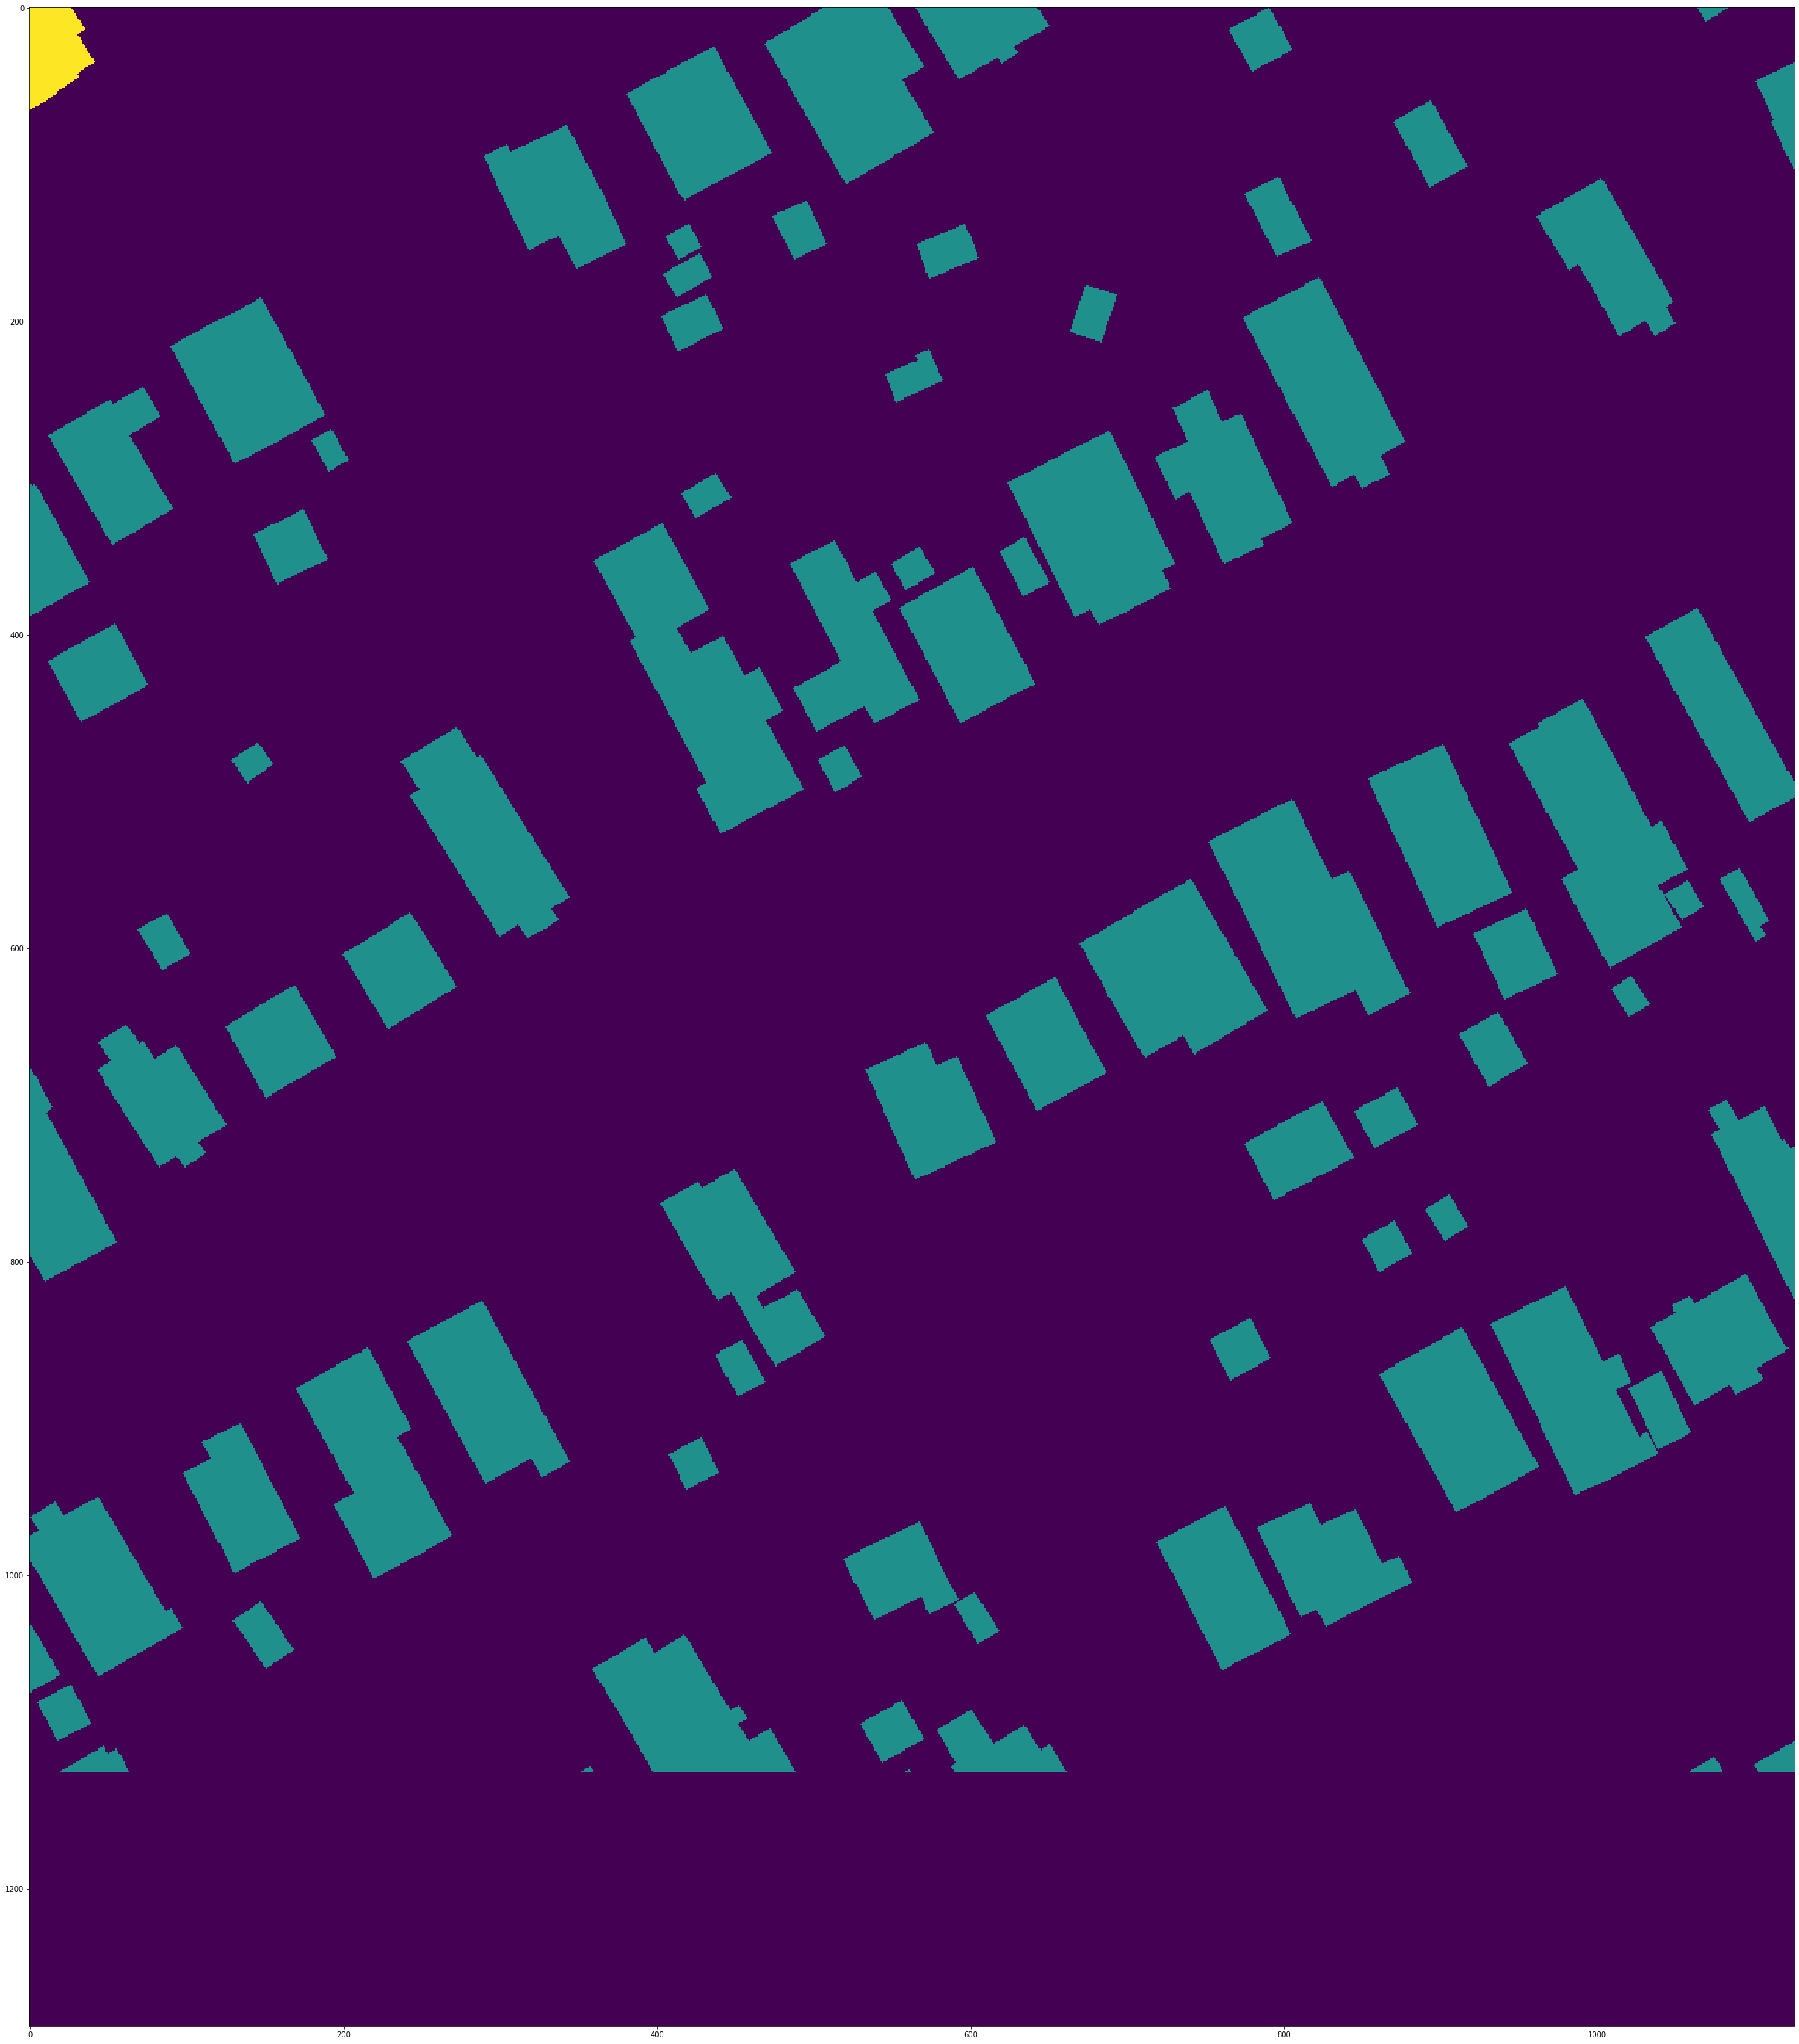

In [5]:
plt.figure(figsize = (50, 50))
plt.imshow(original_mask)